In [6]:
import hashlib
import pathlib
import pymc  # type: ignore
import arviz
import numpy
import matplotlib
import matplotlib.pyplot
import charmonium.time_block
import os; os.chdir("..")
from prov_collectors import baseline
from experiment import get_results
from workloads import WORKLOADS
from prov_collectors import PROV_COLLECTORS, baseline
random_seed = 0
cache = pathlib.Path(".cache")

In [7]:
quality = 2

In [8]:
collectors = [
    collector
    for collector in PROV_COLLECTORS
    if collector.name not in {
        0: {"ltrace", "cde", "rr", "reprozip", "strace"},
        1: {"ltrace", "cde"},
        2: {"ltrace"}
    }[quality]
]
collectors

In [9]:
workloads = [
    workload
    for workload in WORKLOADS
    if workload.name in {
        0: {"megablast-10", "python-imports"},
        1: {"megablast-10", "python-imports", "pmarcelino-comp", "tblastn-10", "blastx-10"},
        2: {"megablast-10", "python-imports", "pmarcelino-comp", "tblastn-10", "blastx-10"},
    }[quality]
]
workloads

In [10]:
with charmonium.time_block.ctx("getting results"):
    df = get_results(
        collectors,
        workloads,
        iterations={0: 2, 1: 2, 2: 4}[quality],
        seed=0,
    )

 > getting results: running


DEBUG:charmonium.logger: > getting results: running
  0%|                                                                                                                          | 0/120 [00:00<?, ?it/s]

 > getting results > setup megablast-10: running


DEBUG:charmonium.logger: > getting results > setup megablast-10: running


 > getting results > setup megablast-10: 0.0s


DEBUG:charmonium.logger: > getting results > setup megablast-10: 0.0s


 > getting results > setup reprozip: running


DEBUG:charmonium.logger: > getting results > setup reprozip: running


 > getting results > setup reprozip: 0.8s


DEBUG:charmonium.logger: > getting results > setup reprozip: 0.8s


 > getting results > megablast-10 in reprozip: running


DEBUG:charmonium.logger: > getting results > megablast-10 in reprozip: running


 > getting results > megablast-10 in reprozip: 1.2s


DEBUG:charmonium.logger: > getting results > megablast-10 in reprozip: 1.2s


 > getting results: 2.0s (err)


DEBUG:charmonium.logger: > getting results: 2.0s (err)


SubprocessError: 
$ env --ignore-environment LD_LIBRARY_PATH=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/lib LIBRARY_PATH=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/lib PATH=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin /nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/setarch --addr-no-randomize /nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/reprozip trace --dir .workdir/log/reprozip /nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/make --directory=.workdir/work/blast-benchmark BLASTN=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/blastn BLASTP=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/blastp BLASTX=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/blastx TBLASTN=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/tblastn TBLASTP=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/tblastp 'MEGABLAST=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/blastn -task megablast -use_index false' 'IDX_MEGABLAST=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/blastn -task megablast -use_index true' 'IDX_MEGABLAST=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/blastn -task megablast -use_index true' 'MAKEMBINDEX=/nix/store/ibrqy2k75z89j78xvga354rcqq26qvyy-env/bin/makembindex -iformat blastdb -old_style_index false' TIME= NM_001000841 NM_001008511 NM_007622 NM_020327 NM_032130 NM_064997 NM_071881 NM_078614 NM_105954 NM_118167 NM_127277 NM_134656 NM_146415 NM_167127 NM_180448


Traceback (most recent call last):
  File "/nix/store/andlkv67n7n10frh58ckprzlml873aad-python3-3.10.12-env/lib/python3.10/site-packages/reprozip/main.py", line 396, in main
    status = args.func(args)
  File "/nix/store/andlkv67n7n10frh58ckprzlml873aad-python3-3.10.12-env/lib/python3.10/site-packages/reprozip/main.py", line 205, in trace
    status = reprozip.tracer.trace.trace(args.cmdline[0],
  File "/nix/store/andlkv67n7n10frh58ckprzlml873aad-python3-3.10.12-env/lib/python3.10/site-packages/reprozip/tracer/trace.py", line 355, in trace
    directory.mkdir()
  File "/nix/store/andlkv67n7n10frh58ckprzlml873aad-python3-3.10.12-env/lib/python3.10/site-packages/rpaths.py", line 833, in mkdir
    os.mkdir(self.path, mode)
OSError: [Errno 30] Read-only file system: b'.workdir/log/reprozip'

Uploading usage statistics is currently disabled
Please help us by providing anonymous usage statistics; you can enable this
by running:
    reprozip usage_report --enable
If you do not want to see this message again, you can run:
    reprozip usage_report --disable
Nothing will be uploaded before you opt in.


$ echo $?
32000

In [32]:
assert baseline.name in df.collector.cat.categories

In [33]:
coords = {
    "data": df.index,
    "workload": df.workload.cat.categories,
    "collector": df.collector.cat.categories,
}
with charmonium.time_block.ctx("model"), pymc.Model(coords=coords) as model:
    workload_idx = pymc.ConstantData(
        "workload_idx",
        df.workload.cat.codes,
        dims="data",
    )
    collector_idx = pymc.ConstantData(
        "collector_idx",
        df.collector.cat.codes,
        dims="data",
    )
    # TODO: rewrite in terms of collector_idx
    is_baseline = df.collector.cat.categories == baseline.name
    workload_runtime = pymc.Exponential(
        "workload_runtime",
        1/10,
        dims="workload",
    )
    workload_syscalls = pymc.ConstantData(
        "workload_syscalls",
        [
            numpy.mean(df[(df["workload"] == workload) & (df["collector"] == "strace")]["n_ops"])
            for workload in df.workload.cat.categories
        ],
        dims="workload",
    )
    workload_syscalls_per_second = pymc.Deterministic(
        "workload_syscalls_per_second",
        workload_syscalls / workload_runtime,
        dims="workload",
    )
    collector_runtime_per_syscall = pymc.math.switch(
        is_baseline,
        0,
        pymc.Exponential(
            "collector_runtime_per_syscall",
            1/1e-3,
            dims="collector",
        ),
    )
    workload_collector_runtime = pymc.Deterministic(
        "workload_collector_runtime",
        workload_runtime[:, numpy.newaxis] + workload_syscalls[:, numpy.newaxis] * collector_runtime_per_syscall[numpy.newaxis, :],
        dims=("workload", "collector"),
    )
    workload_collector_overhead = pymc.Deterministic(
        "workload_collector_overhead",
        workload_collector_runtime / workload_runtime[:, numpy.newaxis],
        dims=("workload", "collector"),
    )
    runtime_stddev = pymc.Exponential("runtime_stddev", 1/1, dims="workload")
    runtime = pymc.Normal(
        "runtime",
        mu=workload_collector_runtime[workload_idx, collector_idx],
        sigma=runtime_stddev[workload_idx],
        observed=df.walltime,
        dims="data",
    )

 > model: running


DEBUG:charmonium.logger: > model: running


 > model: 0.1s


DEBUG:charmonium.logger: > model: 0.1s


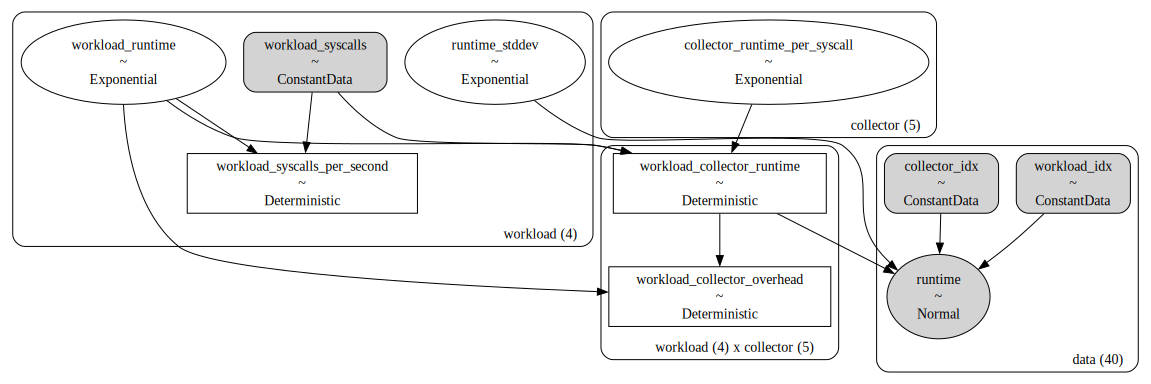

In [34]:
pymc.model_to_graphviz(model)

In [35]:
with charmonium.time_block.ctx("Graphing model"):
    graph = pymc.model_to_graphviz(model)
    graph.render(outfile="output/model.png")
    pathlib.Path("output/model.dot").write_text(graph.source)
    graph_str = hashlib.sha256("\n".join(sorted(graph.source.split("\n"))).encode()).hexdigest()[:10]
    print("model:", graph_str)

 > Graphing model: running


DEBUG:charmonium.logger: > Graphing model: running


model: 4e2fe05b01
 > Graphing model: 0.3s


DEBUG:charmonium.logger: > Graphing model: 0.3s


In [36]:
with charmonium.time_block.ctx("Prior predictive"):
    priors = pymc.sample_prior_predictive(
        random_seed=random_seed,
        model=model,
    )

 > Prior predictive: running


DEBUG:charmonium.logger: > Prior predictive: running
Sampling: [collector_runtime_per_syscall, runtime, runtime_stddev, workload_runtime]
INFO:pymc:Sampling: [collector_runtime_per_syscall, runtime, runtime_stddev, workload_runtime]


 > Prior predictive: 0.3s


DEBUG:charmonium.logger: > Prior predictive: 0.3s


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

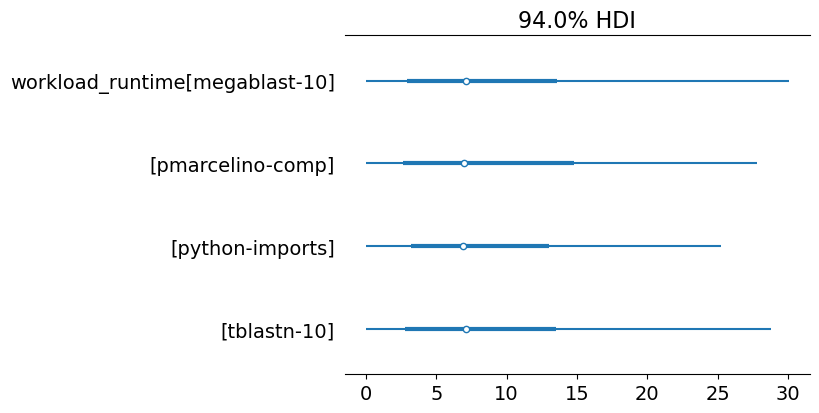

In [37]:
arviz.plot_forest(priors.prior.workload_runtime)

<BarContainer object of 4 artists>

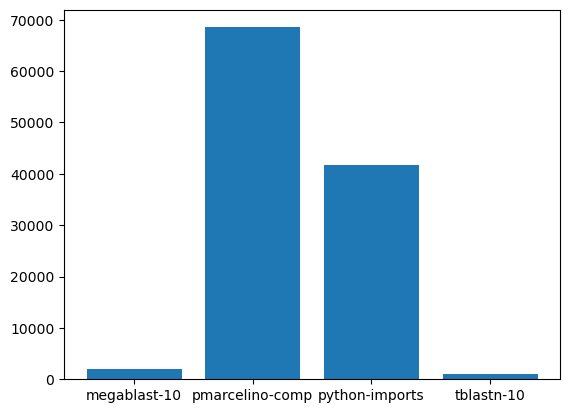

In [38]:
#fig = matplotlib.figure.Figure()
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(df.workload.cat.categories, priors.constant_data.workload_syscalls)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

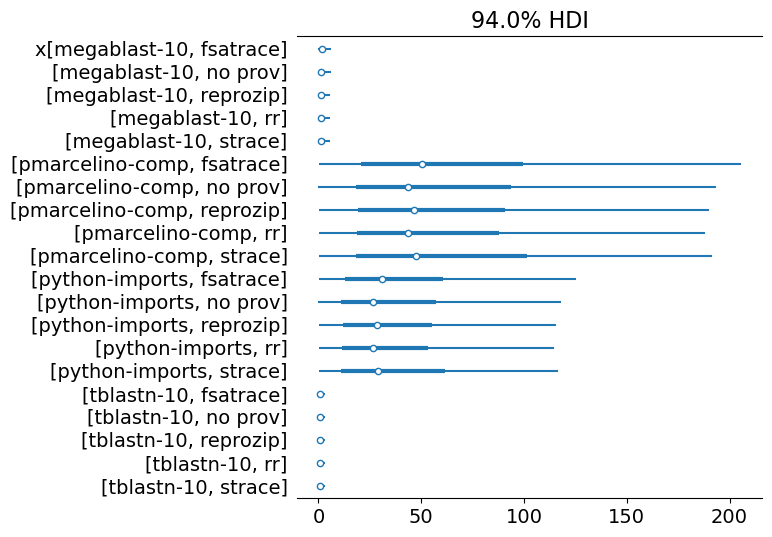

In [39]:
arviz.plot_forest(priors.constant_data.workload_syscalls * priors.prior.collector_runtime_per_syscall)

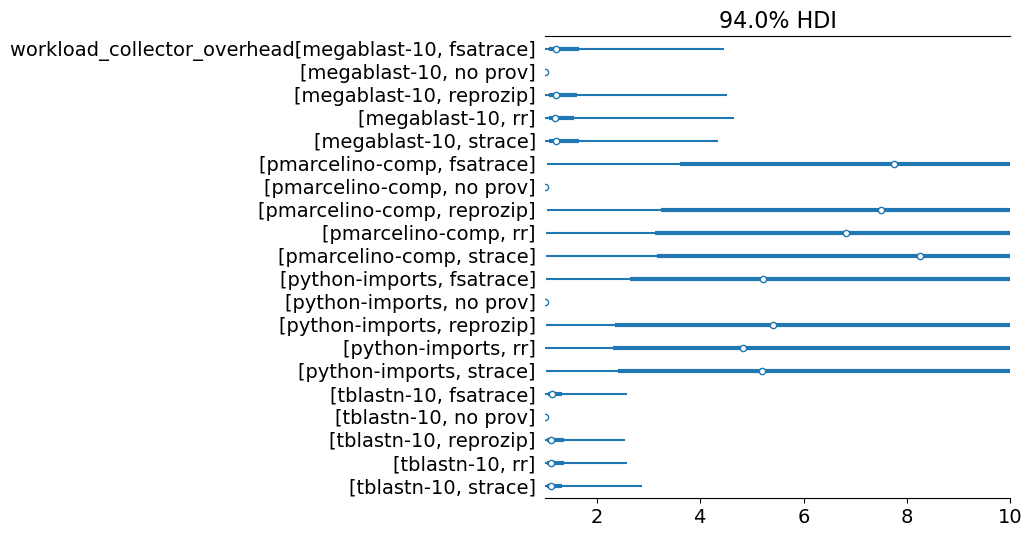

In [49]:
ax = arviz.plot_forest(priors.prior.workload_collector_overhead).ravel()[0]
if ax.get_xlim()[1] > 10:
    ax.set_xlim(1, 10)

In [41]:
with charmonium.time_block.ctx("MCMC"):
    cache_file = cache / f"trace-{graph_str}.hdf5"
    if cache_file.exists():
        trace = arviz.from_netcdf(cache_file)  # type: ignore
    else:
        with model:
            trace = pymc.sample(
                random_seed=random_seed,
                progressbar=True,
                tune={0: 150, 1: 500, 2: 1000}[quality],
                draws={0: 150, 1: 500, 2: 1000}[quality],
                chains={0: 2, 1: 2, 2: 4}[quality],
            )
            trace.to_netcdf(cache_file)  # type: ignore

            # check convergence diagnostics
            assert all(arviz.rhat(trace) < 1.03)  # type: ignore


 > MCMC: running


DEBUG:charmonium.logger: > MCMC: running
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [workload_runtime, collector_runtime_per_syscall, runtime_stddev]
INFO:pymc:NUTS: [workload_runtime, collector_runtime_per_syscall, runtime_stddev]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


 > MCMC: 14.1s


/nix/store/andlkv67n7n10frh58ckprzlml873aad-python3-3.10.12-env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
DEBUG:charmonium.logger: > MCMC: 14.1s


/nix/store/andlkv67n7n10frh58ckprzlml873aad-python3-3.10.12-env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


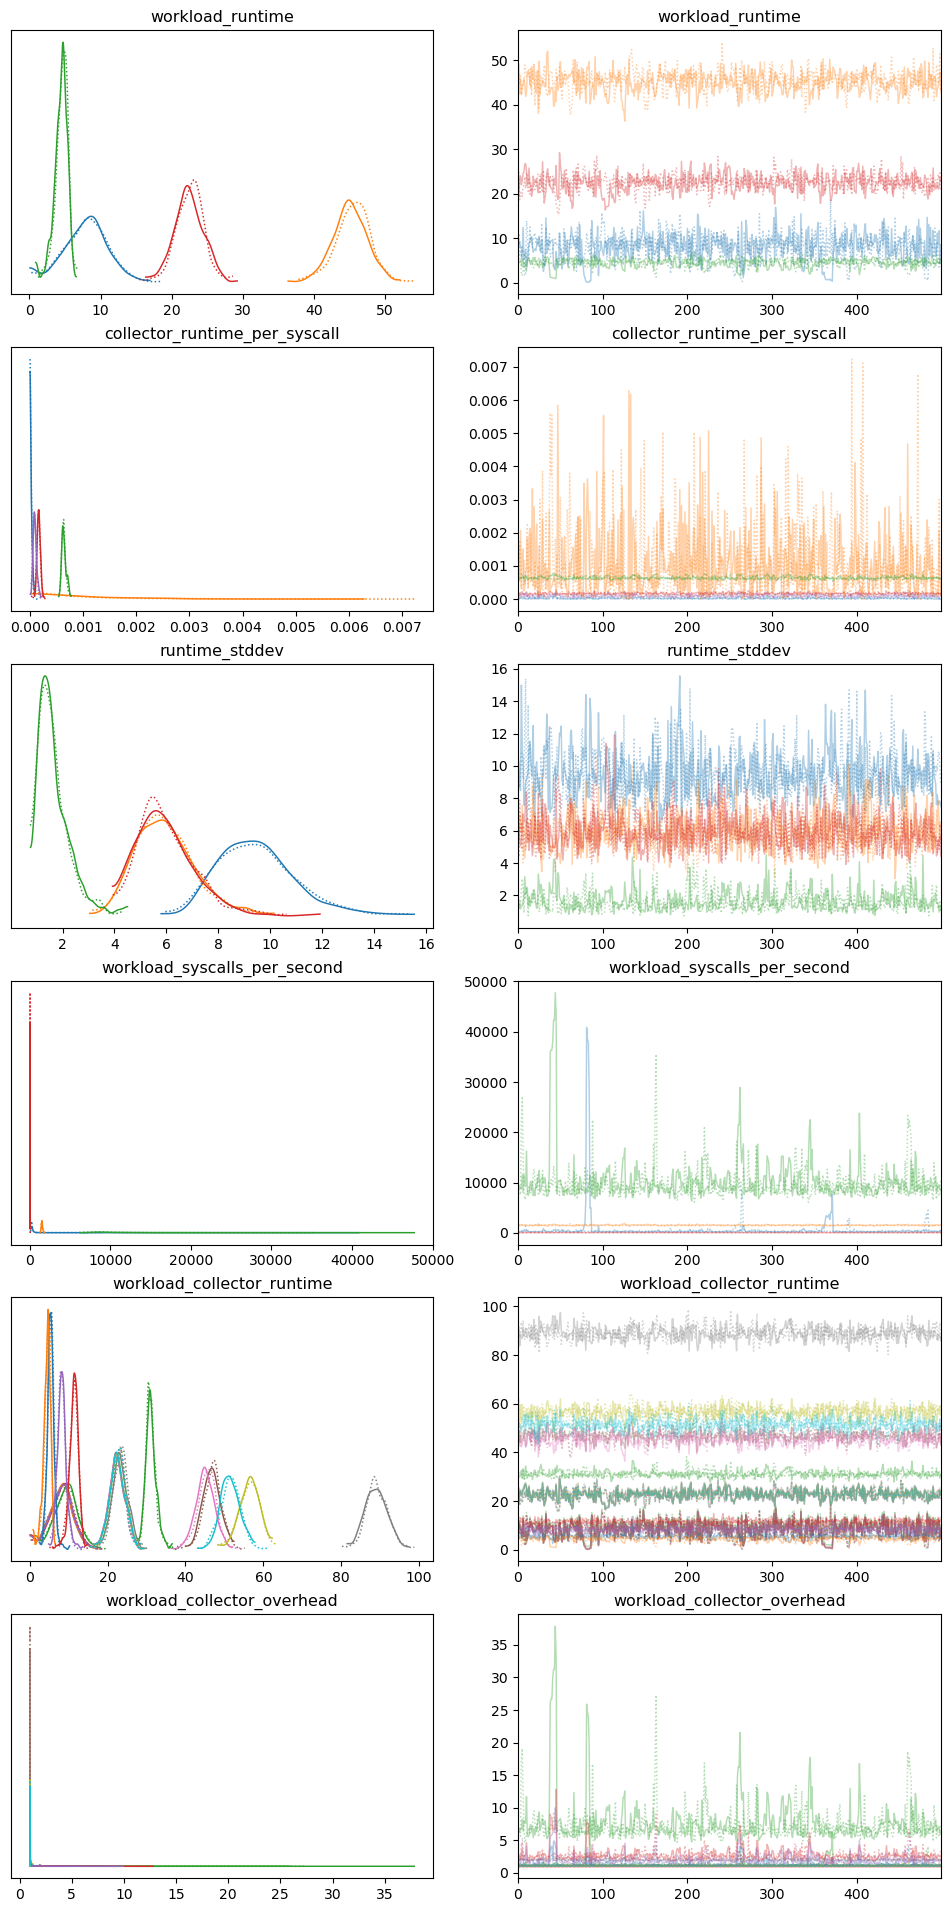

In [42]:
axes = arviz.plot_trace(
    trace,
    figsize=(12, 4 * len(trace.posterior)),
)

In [43]:
model.named_vars

{'workload_idx': workload_idx{[2 1 2 0 0.. 2
  3 3 2]},
 'collector_idx': collector_idx{[1 4 3 1 0.. 2
  1 4 4]},
 'workload_runtime': workload_runtime ~ Exponential(f()),
 'workload_syscalls': workload_syscalls{[ 2078. 68..4.  1105.]},
 'workload_syscalls_per_second': workload_syscalls_per_second ~ Deterministic(f(workload_runtime)),
 'collector_runtime_per_syscall': collector_runtime_per_syscall ~ Exponential(f()),
 'workload_collector_runtime': workload_collector_runtime ~ Deterministic(f(workload_runtime, collector_runtime_per_syscall)),
 'workload_collector_overhead': workload_collector_overhead ~ Deterministic(f(workload_runtime, collector_runtime_per_syscall)),
 'runtime_stddev': runtime_stddev ~ Exponential(f()),
 'runtime': runtime ~ Normal(f(workload_runtime, collector_runtime_per_syscall), f(runtime_stddev))}

In [44]:
def ident(x):
    return x

exclude_baseline = {
    "collector": [
        category
        for category in df.collector.cat.categories
        if category not in {"no prov"}
    ],
}
variables = [
    ("workload_runtime", "sec", ident, None),
    #("workload_syscalls", "#", ident, None),
    ("workload_syscalls_per_second", "K calls / sec", lambda x: x / 1e3, None),
    ("collector_runtime_per_syscall", "log 10 sec", numpy.log10, exclude_baseline),
    ("workload_collector_runtime", "sec", ident, None),
    ("workload_collector_overhead", "overhead (prov ÷ no prov)", ident, None),
    ("runtime_stddev", "sec", ident, None),
]

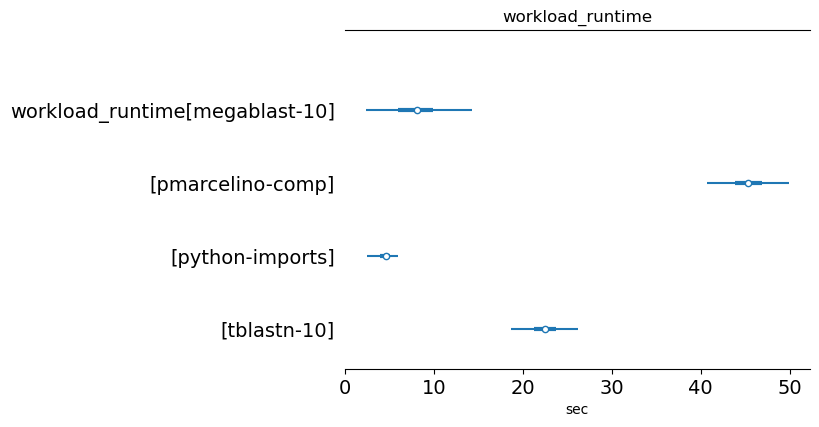

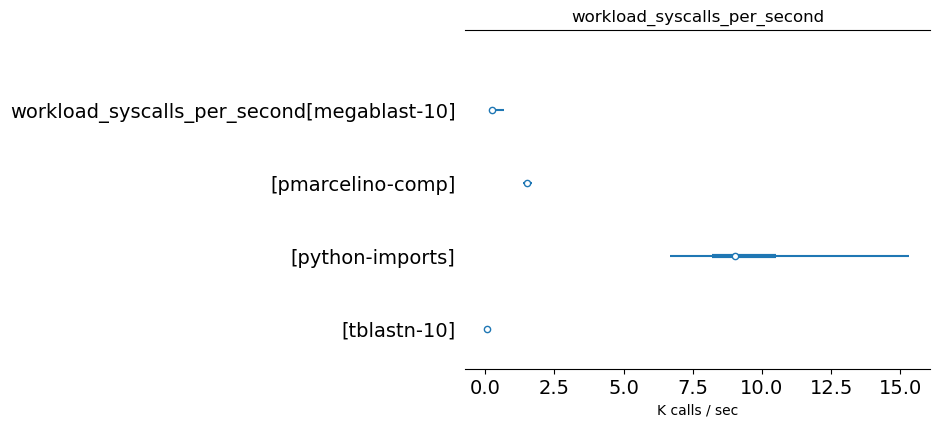

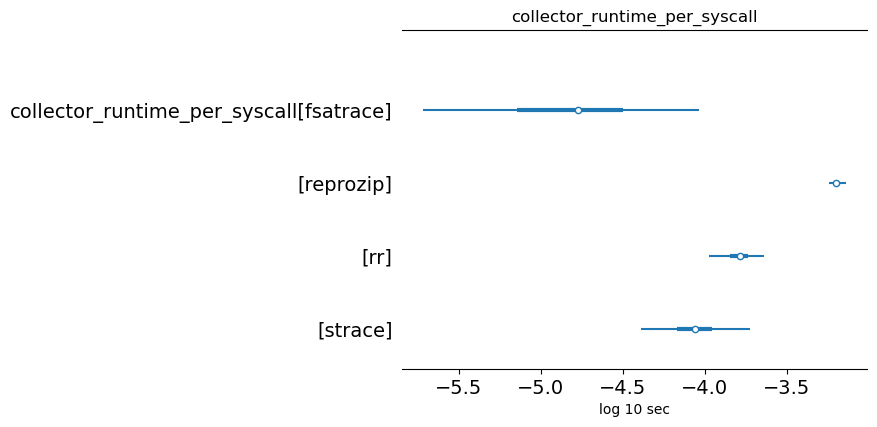

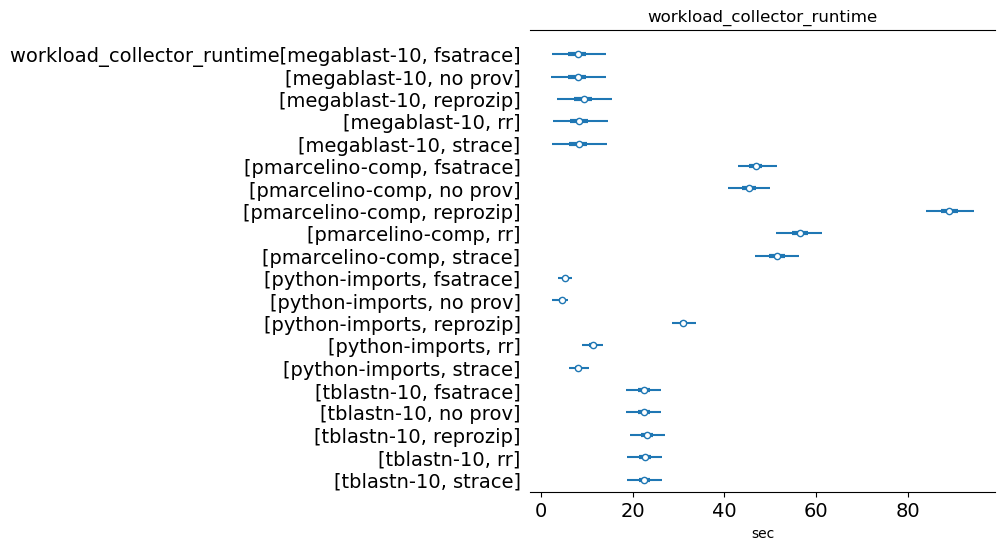

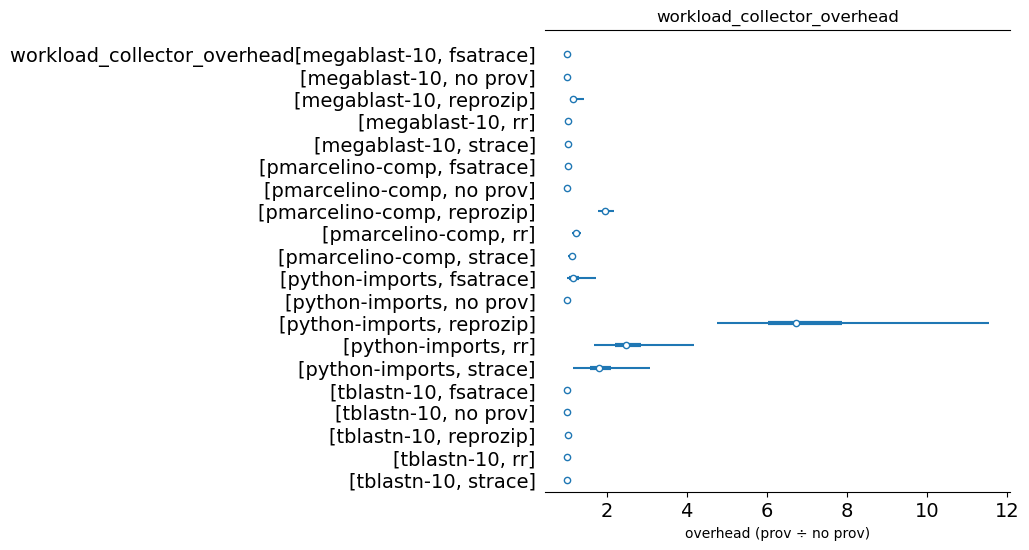

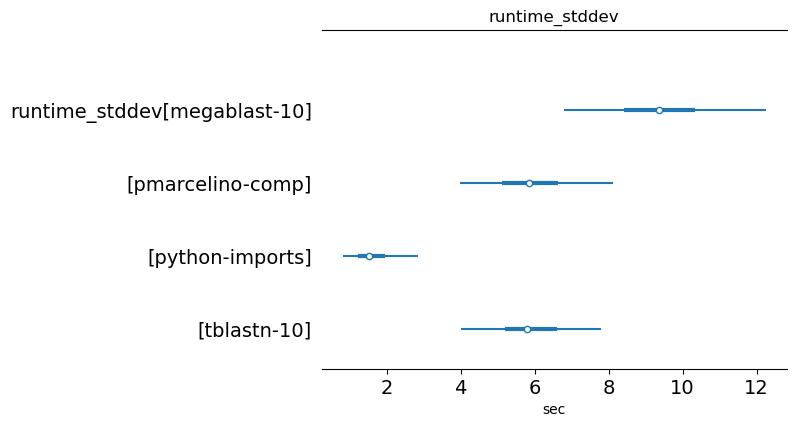

In [45]:
for variable, label, transform, coords in variables:
    axes = arviz.plot_forest(
        trace,
        var_names=[variable],
        transform=transform,
        coords=coords,
        combined=True,
    ).ravel()
    axes[0].set_title(variable)
    axes[0].set_xlabel(label)
    figure = axes[0].figure
    figure.savefig(
        f"output/posterior_forest_{variable}.png",
        bbox_inches="tight",
    )

Text(0.5, 0, 'Total running time (s)')

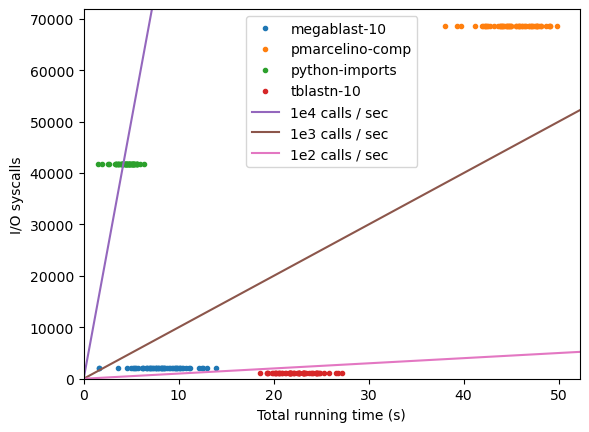

In [57]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
n_points = 30
for workload_idx, workload in enumerate(df.workload.cat.categories):
    ax.plot(
        trace.posterior.workload_runtime.isel(workload=workload_idx, draw=range(n_points)).data.flatten(),
        [trace.constant_data.workload_syscalls.isel(workload=workload_idx)] * n_points * trace.posterior.dims["chain"],
        label=workload,
        marker=".",
        linestyle="",
    )
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
xs = numpy.array(ax.get_xlim())
for rate in ["1e4", "1e3", "1e2"]:
    ax.plot(xs, xs * eval(rate), label=f"{rate} calls / sec", marker="", linestyle="-")
ax.legend()
ax.set_ylabel("I/O syscalls")
ax.set_xlabel("Total running time (s)")